In [1]:
from functools import partial

import plotnine as p9
import polars as pl
from p9customtheme import custom_discrete, custom_theme

from cstbioinfo.embedding import PairedEmbedderModel
from cstbioinfo.embedding.tl import umap

# Define a partial function for UMAP with specific parameters
# So that all models are using the same parameters
umap_partial = partial(umap, n_neighbors=250, min_dist=0.3)

In [2]:
# Download a example dataset from OAS
url = "https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Alsoiussi_2020/csv/SRR11528761_paired.csv.gz"
n = 300
df = pl.read_csv(url, has_header=True, skip_rows=1, separator=",", n_rows=n)

In [3]:
# Initialize the embedder model
model = PairedEmbedderModel.IGBERT
embedder = PairedEmbedderModel.IGBERT.get_embedder(model)

print(f"Downloaded {df.shape[0]} example sequences from OAS.")

Downloaded 300 example sequences from OAS.


In [ ]:
heavy_key = "sequence_alignment_aa_heavy"
light_key = "sequence_alignment_aa_light"

sequences = [
    (heavy, light)
    for heavy, light in zip(
        df.get_column(heavy_key).to_list(), df.get_column(light_key).to_list()
    )
]

# Embed the sequences, this can take a while depending on the model and your hardware
embeddings = embedder.embed(
    sequences=sequences,
)
print(f"Embedded {len(embeddings)} sequences with shape {embeddings[0].shape}.")

Embedding paired sequences:  21%|██        | 4/19 [00:13<00:51,  3.45s/it]

In [ ]:
# quickly make a umap from the embeddings, this can then be combined with the original dataframe
df_umap = umap_partial(embeddings)
df_umap = df_umap.rename(lambda column_name: f"{model.name}_{column_name}")
print(f"Reduced the embeddings to {df_umap.shape} dimensions with UMAP.")

Reduced the embeddings to (300, 2) dimensions with UMAP.


In [ ]:
# Add the UMAP embeddings to the original dataframe
df_embedding = pl.concat([df, df_umap], how="horizontal")

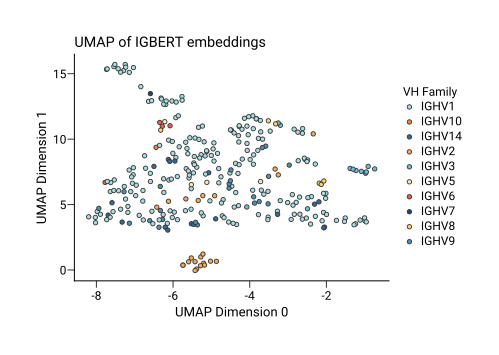

In [ ]:
(
    p9.ggplot(
        df_embedding.with_columns(
            pl.col("v_call_heavy").str.split("-").list.first().alias("VH Family")
        ),
        p9.aes(x="IGBERT_dim_0", y="IGBERT_dim_1", fill="VH Family"),
    )
    + p9.geom_point()
    + custom_discrete()
    + p9.labs(
        title="UMAP of IGBERT embeddings",
        x="UMAP Dimension 0",
        y="UMAP Dimension 1",
        fill="VH Family",
    )
)